# eCommerce Price Prediction


## Import Libraries

In [2]:
# Basic libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Plot related libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Linear Regression Model
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.utils import shuffle

## Load the dataset

The eCommerce price prediction problem has set of data in Train and Test file as comma-separated file. 


In [3]:
TRAIN_FILE = "Train.csv"
TEST_FILE = "Test.csv"

# Using pandas read_csv method to import data
train_ecomm_df = pd.read_csv(TRAIN_FILE, header=0)
test_ecomm_df = pd.read_csv(TEST_FILE, header=0)

Let us check the info of the given dataset.

**Training Set**

In [5]:
train_ecomm_df.info()
print("=="*30)
train_ecomm_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product        2452 non-null   object 
 1   Product_Brand  2452 non-null   object 
 2   Item_Category  2452 non-null   object 
 3   Subcategory_1  2452 non-null   object 
 4   Subcategory_2  2452 non-null   object 
 5   Item_Rating    2452 non-null   float64
 6   Date           2452 non-null   object 
 7   Selling_Price  2452 non-null   float64
dtypes: float64(2), object(6)
memory usage: 153.4+ KB


,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2/3/2017,291.0
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,7/1/2015,897.0
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,1/12/2019,792.0
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,12/12/2014,837.0
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,12/12/2013,470.0


**Test Set**

In [6]:
test_ecomm_df.info()
print("=="*30)
test_ecomm_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product        1051 non-null   object 
 1   Product_Brand  1051 non-null   object 
 2   Item_Category  1051 non-null   object 
 3   Subcategory_1  1051 non-null   object 
 4   Subcategory_2  1051 non-null   object 
 5   Item_Rating    1051 non-null   float64
 6   Date           1051 non-null   object 
dtypes: float64(1), object(6)
memory usage: 57.6+ KB


,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date
0,P-11284,B-2984,computers,network components,routers,4.3,1/12/2018
1,P-6580,B-1732,jewellery,bangles bracelets armlets,bracelets,3.0,20/12/2012
2,P-5843,B-3078,clothing,women s clothing,western wear,1.5,1/12/2014
3,P-5334,B-1421,jewellery,necklaces chains,necklaces,3.9,1/12/2019
4,P-5586,B-3078,clothing,women s clothing,western wear,1.4,1/12/2017


## Exploratory Data Analysis

In [7]:
train_ecomm_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Rating,2452.0,3.078467,1.187137,1.0,2.0,3.1,4.10,5.0
Selling_Price,2452.0,2494.375612,7115.256516,33.0,371.0,596.0,1195.25,116289.0


**Check for null data**

The training set seems to have no null data. 


In [8]:
train_ecomm_df.columns

Index(['Product', 'Product_Brand', 'Item_Category', 'Subcategory_1',
       'Subcategory_2', 'Item_Rating', 'Date', 'Selling_Price'],
      dtype='object')

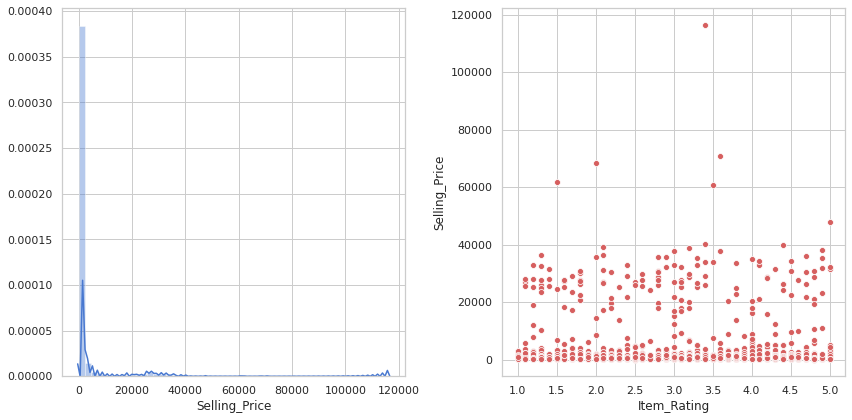

In [9]:
sns.set(style='whitegrid', palette='muted')
fig, ax = plt.subplots(1,2, figsize=(12,6))

sns.distplot(train_ecomm_df['Selling_Price'], kde=True, ax=ax[0])
sns.scatterplot(x='Item_Rating', y='Selling_Price', data=train_ecomm_df, marker='o', color='r', ax=ax[1])

plt.tight_layout()
plt.show()

In [10]:
# Transform the target variable
y_target = np.log1p(train_ecomm_df['Selling_Price'])

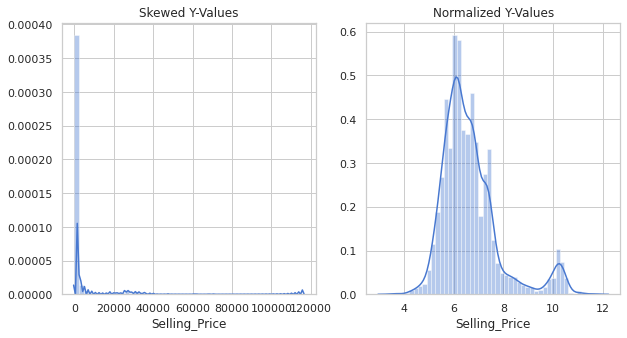

In [11]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
sns.distplot(train_ecomm_df['Selling_Price'], kde=True, ax=axes[0])
sns.distplot(y_target, kde=True, ax=axes[1])
axes[0].set_title("Skewed Y-Values")
axes[1].set_title("Normalized Y-Values")
plt.show()

## Prepare data for model building

The dataset contains date and few categorical columns. We need to encode the categorical columns to number before building a model. 

In [12]:
# Merge train and test data
tempset = pd.concat([train_ecomm_df, test_ecomm_df], keys=[0,1])

# Impute the 'unknown' values with Mode
tempset['Subcategory_1'] = tempset['Subcategory_2'].replace('unknown', np.nan).bfill().ffill()
tempset['Subcategory_2'] = tempset['Subcategory_2'].replace('unknown', np.nan).bfill().ffill()

tempset['Subcategory_1'] = tempset['Subcategory_1'].fillna(tempset['Subcategory_1'].mode()[0])
tempset['Subcategory_2'] = tempset['Subcategory_2'].fillna(tempset['Subcategory_2'].mode()[0])

In [13]:
tempset.drop(['Date', 'Product'], axis=1, inplace=True)

In [15]:
# Getting the categorical columns
cat_data = tempset.select_dtypes(include=['object'])

# One-hot encoding
X_encode = pd.get_dummies(tempset, columns=cat_data.columns)

# Getting back the Tran and Test data
X_train, X_enc_test = X_encode.xs(0), X_encode.xs(1)

## Define X and Y 

In [16]:
# Prepare X and y for fitting the model
y = X_train['Selling_Price'].values
X = X_train.drop('Selling_Price', axis=1).values

X_test = X_enc_test.drop('Selling_Price', axis=1)

## Building Linear Regression Model

### Using TransformedTargetRegressor model

This model allows us to use cross-validation and regularizer functions such as Ridge and Lasso

## Ridge CV implementation

In [17]:
ridge_cv = RidgeCV(normalize=True,cv=10,gcv_mode='svd',scoring='neg_mean_squared_error')

#Initializing Linear Regression algorithm with Ridge regularizer(K-fold with 10 folds)
ridge_reg = TransformedTargetRegressor(regressor= ridge_cv,
                                      func=np.log1p,
                                      inverse_func=np.expm1)

In [18]:
ridge_reg.fit(X, y)

# Predict the test data
predictions = ridge_reg.predict(X_test)

In [25]:
final_df = pd.DataFrame({'Selling_Price': predictions})

final_df['Selling_Price'] = final_df.apply(lambda x: round(x, 2))
final_df = pd.concat([test_ecomm_df, final_df['Selling_Price']], axis=1)

In [27]:
final_df.head(20)

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price
0,P-11284,B-2984,computers,network components,routers,4.3,1/12/2018,1783.22
1,P-6580,B-1732,jewellery,bangles bracelets armlets,bracelets,3.0,20/12/2012,705.53
2,P-5843,B-3078,clothing,women s clothing,western wear,1.5,1/12/2014,601.50
3,P-5334,B-1421,jewellery,necklaces chains,necklaces,3.9,1/12/2019,403.13
4,P-5586,B-3078,clothing,women s clothing,western wear,1.4,1/12/2017,602.04
5,P-11206,B-3078,clothing,women s clothing,western wear,2.1,3/12/2018,598.26
6,P-9966,B-2609,mobiles accessories,mobile accessories,speakers,2.8,20/5/2015,469.17
7,P-5367,B-1431,jewellery,rings,unknown,4.9,7/1/2016,11962.15
8,P-9075,B-2326,jewellery,rings,unknown,4.9,1/1/2015,17140.90
9,P-8852,B-449,clothing,women s clothing,lingerie sleep swimwear,4.5,7/1/2018,293.73
